In [1]:
#Importing the base modules
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms  #Has lots of pre-trained models 
#Modules for training
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
#Other hellpful libraries
import numpy as np
import matplotlib.pyplot as plt

import time
import os
# import copy

#plt.ion()  

print(torch.cuda.is_available()) #To know if CUDA-supported GPU is available to use

True


## Loading Dataset for Training

In [2]:
data_dir = './data'
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

data_transforms = {  
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([      
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    'train': datasets.ImageFolder(    
        os.path.join(data_dir, train_dir), 
        transform=data_transforms['train']
    ),
    'val': datasets.ImageFolder(    
        os.path.join(data_dir, val_dir), 
        transform=data_transforms['val']
    ),
    'test': datasets.ImageFolder(    
        os.path.join(data_dir, test_dir), 
        transform=data_transforms['test']
    ),
}

dataloaders = {    
    'train': torch.utils.data.DataLoader(
        image_datasets['train'], batch_size=4,
        shuffle=True, num_workers=7
    ),
    'val': torch.utils.data.DataLoader(
        image_datasets['val'], batch_size=4,
        shuffle=True, num_workers=7
    ),
    'test': torch.utils.data.DataLoader(
        image_datasets['test'], batch_size=4,
        shuffle=True, num_workers=7
    ),
}

for x in image_datasets.keys():
    print(x,len(image_datasets[x]))
    
print("Classes: ", image_datasets["train"].classes)

train 8396
val 2798
test 2800
Classes:  ['fake', 'real']


## Displaying data

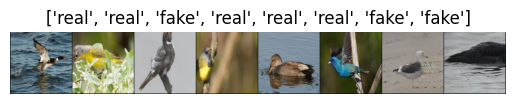

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    #plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[image_datasets["train"].classes[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
show_databatch(inputs, classes)

### Due to my Low Laptop GPU Vram, I took a low batch size of 2, Although it slows down training, however, the accuracy and loss will be relatively better than with higher batch sizes

## Model Training

I used pretrained models available with pytorch. Since they were trained on imageNet dataset with 1000 classes $\therefore$ they have 1000 output features in the end, so I willl replace the last fully connected layer of the model with a new one with 2 output features (real/fake) as per our dataset.

For Learning rate I set an initial learning rate of 10^-4 and used a scheduler which multiplies the learning rate with a certain $\gamma$ after every set epochs, in this case, multiplies by 0.1 after every 5 epochs

In [5]:
def train(name, model, criterion, optimizer, scheduler, num_epochs=10):
    start = time.time()
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    history = {'ta':[],'tl':[],'va':[],'vl':[]}
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs}")
        print('----------')
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0

        #Start the training
        model.train(True)        
        for i, data in enumerate(dataloaders['train']):
            if(i%100 == 0):
                print("\rTraining batch {}/{}".format(i, len(dataloaders['train'])/2), end='', flush=True)
                print()
            if(i >= len(dataloaders['train'])/2):
                break
            inputs, labels = data
            (inputs, labels) = ((Variable(inputs), Variable(labels)),(Variable(inputs.cuda()), Variable(labels.cuda())))[torch.cuda.is_available()]
            optimizer.zero_grad()
            outputs = model(inputs)
            preds = torch.max(outputs.data, 1)[1]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        avg_loss = loss_train * 2 / 20000
        avg_acc = acc_train * 2 / 20000
        model.train(False)

        #Start the evaluation
        model.eval()
        for i, data in enumerate(dataloaders['val']):
            if i % 100 == 0:
                print(f"\rValidation batch {i}/{len(dataloaders['val'])}", end='', flush=True)
            with torch.no_grad():     #This is to not store any gradients as we won't be doing backpropagation now.
                inputs, labels = data
                (inputs, labels) = ((Variable(inputs), Variable(labels)),(Variable(inputs.cuda()), Variable(labels.cuda())))[torch.cuda.is_available()]
                optimizer.zero_grad()                
                outputs = model(inputs)                
                preds = torch.max(outputs.data, 1)[1]
                loss = criterion(outputs, labels)                
                loss_val += loss.item()
                acc_val += torch.sum(preds == labels.data)                
                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / 4000
        avg_acc_val = acc_val / 4000

        #Save the model
        if(epoch%5 == 0):
            torch.save(model.state_dict(), f'{name}_{epoch}.pt')
        #Print the results and store them
        history['ta'].append(avg_acc)
        history['tl'].append(avg_loss)
        history['va'].append(avg_acc_val)
        history['vl'].append(avg_loss_val)
        print(f"\nEpoch {epoch} result: ")
        print(f"Training loss: [{avg_loss}]")
        print(f"Training acc: [{avg_acc}]")
        print(f"Validation loss: [{avg_loss_val}]")
        print(f"Validation acc: [{avg_acc_val}]")
        print('----------\n')
        
    train_time = time.time() - start
    print(f"\nTraining time: {train_time//60}m {train_time%60}s")
    return history

### First we'll train with the improved version of classic ResNet model, the ResneXt model!
It has best of both worlds of Resnet and inception. It does multiple parallel convolutions like in inception model along with a skip connection at the end like the ResNet!

In [5]:
resnext = models.resnext101_32x8d(weights='IMAGENET1K_V2')
resnext.fc = nn.Sequential(
    resnext.fc,
    nn.Linear(in_features=1000, out_features=512, bias=True),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.Linear(in_features=256, out_features=2, bias=True),
)
print(resnext)
model = resnext

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [6]:
model.cuda() #.cuda() will move the model to the GPU side
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.8) #initital learning rate of 10^-4
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)  #Scheduler
resnext_data = train('resnext',model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/30
----------
Training batch 0/525.0
Training batch 100/525.0
Training batch 200/525.0
Training batch 300/525.0
Training batch 400/525.0
Training batch 500/525.0
Validation batch 300/350
Epoch 0 result: 
Training loss: [0.03394071882367134]
Training acc: [0.2651999890804291]
Validation loss: [0.05841703990846872]
Validation acc: [0.4162500202655792]
----------

Epoch 1/30
----------
Training batch 0/525.0
Training batch 100/525.0
Training batch 200/525.0
Training batch 300/525.0
Training batch 400/525.0
Training batch 500/525.0
Validation batch 300/350
Epoch 1 result: 
Training loss: [0.03103436489254236]
Training acc: [0.2888999879360199]
Validation loss: [0.055128698714077475]
Validation acc: [0.45375001430511475]
----------

Epoch 2/30
----------
Training batch 0/525.0
Training batch 100/525.0
Training batch 200/525.0
Training batch 300/525.0
Training batch 400/525.0
Training batch 500/525.0
Validation batch 300/350
Epoch 2 result: 
Training loss: [0.02872635143697262]
Train

KeyboardInterrupt: 

In [6]:
#SWIN TRANSFORMER        
model = models.swin_v2_b(weights='IMAGENET1K_V1')
model.head = nn.Sequential(
    model.head,
    nn.Linear(in_features=1000, out_features=512, bias=True),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.Linear(in_features=256, out_features=2, bias=True),
)
print(model)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(appro

In [7]:
model.cuda() #.cuda() will move the model to the GPU side
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.8) #initital learning rate of 10^-4
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)  #Scheduler
swint_train = train('SwinT_New',model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=21)

Epoch 0/21
----------
Training batch 0/525.0
Training batch 100/525.0
Training batch 200/525.0
Training batch 300/525.0
Training batch 400/525.0
Training batch 500/525.0
Validation batch 300/350
Epoch 0 result: 
Training loss: [0.036064769923686985]
Training acc: [0.23070000112056732]
Validation loss: [0.06020861429721117]
Validation acc: [0.3907500207424164]
----------

Epoch 1/21
----------
Training batch 0/525.0
Training batch 100/525.0
Training batch 200/525.0
Training batch 300/525.0
Training batch 400/525.0
Training batch 500/525.0
Validation batch 300/350
Epoch 1 result: 
Training loss: [0.03408903866708279]
Training acc: [0.2620999813079834]
Validation loss: [0.055046183757483956]
Validation acc: [0.4582500159740448]
----------

Epoch 2/21
----------
Training batch 0/525.0
Training batch 100/525.0
Training batch 200/525.0
Training batch 300/525.0
Training batch 400/525.0
Training batch 500/525.0
Validation batch 300/350
Epoch 2 result: 
Training loss: [0.03294684630036354]
Trai

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 3.81 GiB total capacity; 3.59 GiB already allocated; 4.44 MiB free; 3.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [26]:
swint_train

{'ta': [tensor(0.0897, device='cuda:0'),
  tensor(0.0976, device='cuda:0'),
  tensor(0.1115, device='cuda:0'),
  tensor(0.1149, device='cuda:0'),
  tensor(0.1185, device='cuda:0'),
  tensor(0.1198, device='cuda:0'),
  tensor(0.1184, device='cuda:0'),
  tensor(0.1208, device='cuda:0'),
  tensor(0.1234, device='cuda:0'),
  tensor(0.1205, device='cuda:0'),
  tensor(0.1229, device='cuda:0'),
  tensor(0.1241, device='cuda:0'),
  tensor(0.1249, device='cuda:0'),
  tensor(0.1237, device='cuda:0'),
  tensor(0.1263, device='cuda:0'),
  tensor(0.1247, device='cuda:0'),
  tensor(0.1245, device='cuda:0'),
  tensor(0.1255, device='cuda:0'),
  tensor(0.1260, device='cuda:0'),
  tensor(0.1262, device='cuda:0'),
  tensor(0.1249, device='cuda:0'),
  tensor(0.1256, device='cuda:0'),
  tensor(0.1263, device='cuda:0'),
  tensor(0.1263, device='cuda:0'),
  tensor(0.1261, device='cuda:0'),
  tensor(0.1255, device='cuda:0'),
  tensor(0.1256, device='cuda:0'),
  tensor(0.1267, device='cuda:0'),
  tensor(0.126

### Similarly Trying EfficientNet and VGG16:

In [6]:
#EFFICIENTNET V2
model = models.efficientnet_v2_l(weights='IMAGENET1K_V1')
model.classifier = nn.Sequential(
    model.classifier,
    nn.Linear(in_features=1000, out_features=512, bias=True),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.Linear(in_features=256, out_features=2, bias=True),
)
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [6]:
model.cuda() #.cuda() will move the model to the GPU side
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.8) #initital learning rate of 10^-4
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)  #Scheduler
train('EfficientNetV2',model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

In [7]:
model = models.vgg16_bn()

features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(model.classifier[6].in_features, len(class_names))])
model.classifier = nn.Sequential(*features)

model.cuda() #.cuda() will move the model to the GPU side
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.8) #initital learning rate of 10^-4
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)  #Scheduler
train('VGG16',model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

### Training Graphs


#### ResneXt101

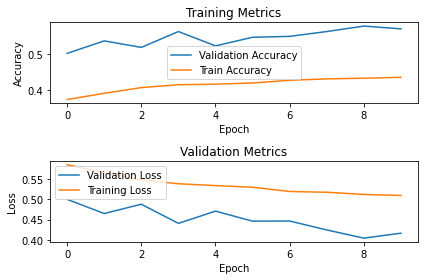

In [3]:
import matplotlib.pyplot as plt
import numpy as np

#Stats from previous Training sessions
# Train loss
rtl = np.array([0.5853034923043101, 0.5654620873172768, 0.5475117765548871, 0.5383564840638079, 0.5338668791702599, 0.5297615264410036, 0.5192875182801509, 0.5174428717202972, 0.512080996466591, 0.5094343832732877])
# Train accuracy
rta = [0.37379995584487913, 0.39109996557235716, 0.4070999979972839, 0.4150999546051025, 0.41659996509552, 0.4199999928474426, 0.42749998569488523, 0.4313999772071838, 0.43329999446868894, 0.43569997549057005]
# Validation loss
rvl = np.array([0.49998865252267566, 0.46506709882360886, 0.48797928151412634, 0.4408842703904374, 0.47098754197047676, 0.44628810388967394, 0.4466427782351093, 0.4247004995375755, 0.4045591758937226, 0.41668766987917477])
# Validation accuracy
rva = [0.5025000214576721, 0.5375000476837158, 0.5192500591278076, 0.5635000705718994, 0.5235000491142273, 0.5475000381469727, 0.5500000357627869, 0.5635000705718994, 0.5787500381469727, 0.5710000634193421]
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plot the training metrics
ax1.plot(rva, label='Validation Accuracy')
ax1.plot(rta, label='Train Accuracy')
ax1.set_title('Training Metrics')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot the validation metrics
ax2.plot(rvl, label='Validation Loss')
ax2.plot(rtl, label='Training Loss')
ax2.set_title('Validation Metrics')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Show the plot
plt.tight_layout()
plt.show()

#### Swin Transformer

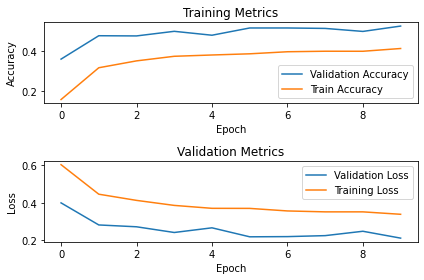

In [4]:
#Stats from previous Training sessions
swint_stats = {
    'ta': [0.1582,0.31689999999999996,0.35119999999999996,0.3741,0.38059999999999994,0.38649999999999995,0.39679999999999993,0.3994,0.3992,0.4129999999999999],
    'tl': [0.6036154819425196,0.44581809920147064,0.41276841371322515,0.3859502506433986,0.3703392516996944,0.36998190122659436,0.3563413662285835,0.351453736232355,0.35144764736744105,0.33845118590096823],
    'va': [0.36,0.4768,0.4758,0.4988,0.47929999999999995,0.5155,0.5155,0.5133,0.49829999999999997,0.525],
    'vl': [0.3994451138786972,0.28147628733608876,0.27169252215896267,0.2411776969441853,0.2661546719376056,0.21810901979365738,0.21915531391868717,0.22439800015209765,0.24776504340255634,0.21106579233691447]
}
# Train loss
rtl = np.array(swint_stats['tl'])
# Train accuracy
rta = np.array(swint_stats['ta'])
# Validation loss
rvl = np.array(swint_stats['vl'])
# Validation accuracy
rva = np.array(swint_stats['va'])

fig, (ax1, ax2) = plt.subplots(2, 1)

# Plot the training metrics
ax1.plot(rva, label='Validation Accuracy')
ax1.plot(rta, label='Train Accuracy')
ax1.set_title('Training Metrics')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot the validation metrics
ax2.plot(rvl, label='Validation Loss')
ax2.plot(rtl, label='Training Loss')
ax2.set_title('Validation Metrics')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Show the plot
plt.tight_layout()
plt.show()